In [41]:
import matplotlib.pyplot as plt
import numpy as np
import scipy

import sklearn.metrics as sm

import matplotlib.ticker as ticker
import seaborn as sns
import matplotlib as mpl
from matplotlib.lines import Line2D
from matplotlib.gridspec import GridSpec

## Influence of the negative embeddings on performance

Testing clip with rand-word
Testing clip with rand-emb
Testing align with rand-word
Testing align with rand-emb
Testing imagebind with rand-word
No data for imagebind 5000_word
Testing imagebind with rand-emb
No data for imagebind 5000_emb


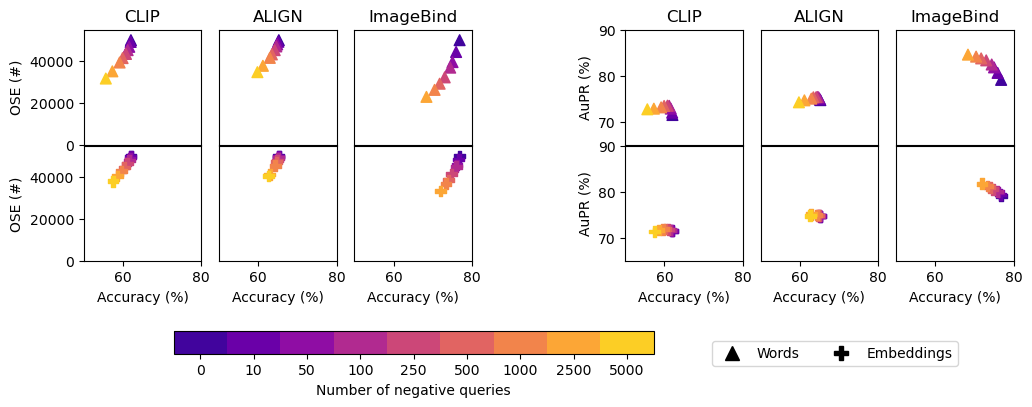

In [48]:
cols = sns.color_palette("plasma", n_colors = 9)

markerTypes = ['^', 'P']
modelNames = ['CLIP', 'ALIGN', 'ImageBind']


fig = plt.figure(figsize = (12, 3))
gs1 = GridSpec(2, 7)
ax1 = [[[], [], []], [[], [], []]]
ax2 = [[[], [], []], [[], [], []]]

for mIdx, modelType in enumerate(['clip', 'align', 'imagebind']):
    for tIdx, typ in enumerate(['word', 'emb']):
        print(f'Testing {modelType} with rand-{typ}')
        all_acc = []
        all_aupr = []
        all_ose = []
        for neg_count in [0, 10, 50, 100, 250, 500, 1000, 2500, 5000]:
            if neg_count == 0:
                type = 'standard'
            else:
                type = f'{neg_count}_{typ}'
            try:
                gt_labels = np.load(f'../pred_files/{modelType}/imagenet/{type}_gt_{modelType}.npy')
                all_cosine = np.load(f'../pred_files/{modelType}/imagenet/{type}_cosine_{modelType}.npy')
            except:
                print(f'No data for {modelType} {type}')
                continue
                
            raw_results = {'softmax': [[], []]}
            num_classes = 1000
            for idx in range(len(all_cosine)):
                target = gt_labels[idx]    
                cosine = all_cosine[idx]
        
                softmax = scipy.special.softmax(cosine)
                pred_idx = np.argmax(softmax)
                pred_score = softmax[pred_idx]

                correct = pred_idx == target
            
                if correct:
                    raw_results['softmax'][0] += [pred_score]

                ###################################################################################
                known_classes = np.concatenate((np.arange(0, target), np.arange(target+1, len(cosine))))
        
                cosine_subset = cosine[known_classes]
            
                softmax = scipy.special.softmax(cosine_subset)
                pred_idx = np.argmax(softmax)
        
                if pred_idx >= (num_classes-1): #-1 because we removed the target class
                    continue
                
                pred_score = softmax[pred_idx]
                raw_results['softmax'][1] += [pred_score]

           
            for kIdx, k in enumerate(raw_results.keys()):
                known_c = raw_results[k][0]
                unknown = raw_results[k][1]
                acc = len(known_c)/len(gt_labels)

                true = np.concatenate((np.ones(len(known_c)), np.zeros(len(unknown))))
                scores = np.concatenate((known_c, unknown))
              
              
                precision, recall, thresholds = sm.precision_recall_curve(true, scores)
                aupr = sm.auc(recall, precision)

                all_ose += [len(unknown)]
                all_acc += [100.*acc]
                all_aupr += [100.*aupr]

                
        ax1[tIdx][mIdx] = fig.add_subplot(gs1[tIdx, mIdx])
        ax2[tIdx][mIdx] = fig.add_subplot(gs1[tIdx, mIdx+4])


        
        acc = all_acc
        ose = all_ose
        aupr = all_aupr
        
        ax2[tIdx][mIdx].scatter(acc, aupr, c = cols[:len(acc)], marker = markerTypes[tIdx], s = 60)
        ax1[tIdx][mIdx].scatter(acc, ose, c = cols[:len(acc)], marker = markerTypes[tIdx], s = 60)   

        if tIdx == 1:
            ax1[tIdx][mIdx].set_xlabel('Accuracy (%)')
            ax2[tIdx][mIdx].set_xlabel('Accuracy (%)')
            
        if mIdx == 0:
            ax2[tIdx][mIdx].set_ylabel('AuPR (%)')
            ax1[tIdx][mIdx].set_ylabel('OSE (#)')
           

        ax2[tIdx][mIdx].set_ylim(65, 90)#17000)
        ax1[tIdx][mIdx].set_ylim(0, 55000)#
        ax2[tIdx][mIdx].set_xlim(50, 80)#17000)
        ax1[tIdx][mIdx].set_xlim(50, 80)#17000)

        if tIdx == 0:
            ax2[tIdx][mIdx].title.set_text(modelNames[mIdx])
            ax1[tIdx][mIdx].title.set_text(modelNames[mIdx])

        if mIdx != 0:
            ax2[tIdx][mIdx].set_yticks([])
            ax1[tIdx][mIdx].set_yticks([])
            
        if tIdx == 0:
            ax2[tIdx][mIdx].set_xticks([])
            ax1[tIdx][mIdx].set_xticks([])

cmap = mpl.colors.ListedColormap(cols)
cmap.set_over('0.25')
cmap.set_under('0.75')

cax = fig.add_axes([0.2, -0.2, 0.4, 0.075])

bounds = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]#10, 50, 100, 250, 500, 1000, 2500, 5000]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
cb2 = mpl.colorbar.ColorbarBase(cax, cmap=cmap,
                                norm=norm,
                                boundaries=bounds,
                    
                                ticks=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5],
                                
                                # spacing='proportional',
                                orientation='horizontal')

cb2.minorticks_off()
cb2.set_ticklabels(['0', '10', '50', '100', '250', '500', '1000', '2500', '5000'])

cb2.set_label('Number of negative queries')


legend_elements = [Line2D([0], [0], color='k', marker = '^', markersize = 10, lw = 0, label='Words'),
                   Line2D([0], [0], color='k', marker = 'P', markersize = 10, lw = 0, label='Embeddings')]

fig.legend(handles = legend_elements, loc = (0.69, 0.1), ncols = 2)

plt.subplots_adjust(hspace = 0.01, wspace = 0.15)
plt.savefig('../figures/acc_vs_metrics_negembeddings.pdf', bbox_inches = 'tight')
plt.show()

## How many closed-set images versus open-set images do the negative embeddings capture?

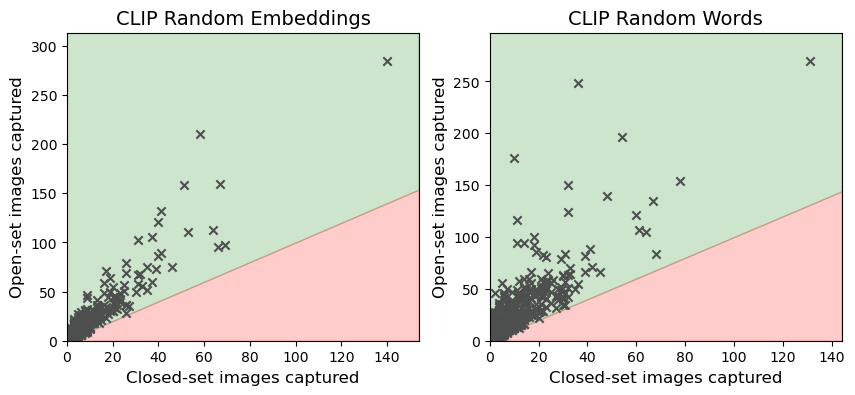

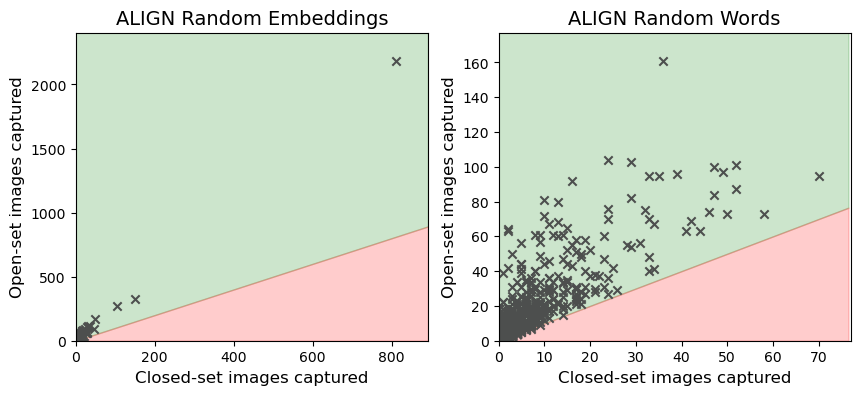

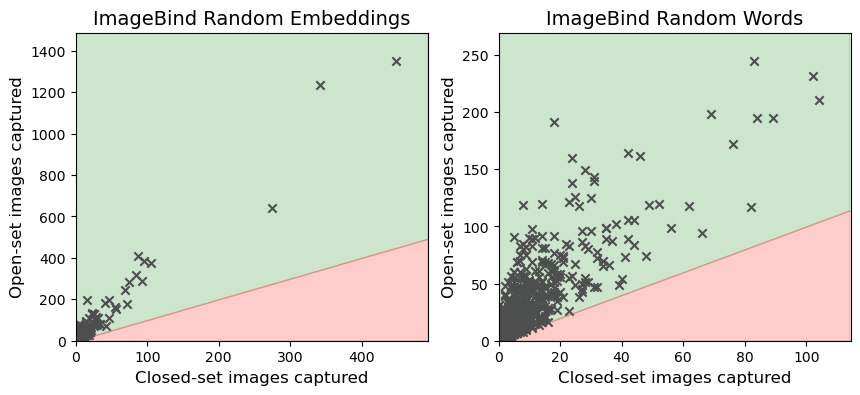

In [17]:
num_neg = 2500
neg_types = 'words'

markerTypes = ['X', 'o', '^']
cols = ['#D85959', '#F59D3B', '#32A7BF', '#545154']

modelNames = ['CLIP', 'ALIGN', 'ImageBind']

for mIdx, modelType in enumerate(['clip', 'align', 'imagebind']):
    fig, ax = plt.subplots(1, 2, figsize = (10, 4))
    for tIdx, typ in enumerate(['emb', 'word']):
        num_times_cs = [0 for i in range(2500)]
        num_times_ose = [0 for i in range(2500)]

        try:
            gt_labels = np.load(f'../pred_files/{modelType}/imagenet/2500_{typ}_gt_{modelType}.npy')
            all_cosine = np.load(f'../pred_files/{modelType}/imagenet/2500_{typ}_cosine_{modelType}.npy')
        except:
            print(f'No data for {modelType} 2500 {typ}')
            continue
                
        raw_results = {'softmax': [[], [], []], 'cosine': [[], [], []], 'entropy': [[], [], []]}
        num_classes = 1000
        for idx in range(len(all_cosine)):
            target = gt_labels[idx]    
            cosine = all_cosine[idx]
    
            softmax = scipy.special.softmax(cosine)
            pred_idx = np.argmax(softmax)

            #was this closed-set image misclassified as a negative embedding
            if pred_idx >= num_classes:
                num_times_cs[pred_idx-num_classes]+= 1
             
            ###################################################################################
            known_classes = np.concatenate((np.arange(0, target), np.arange(target+1, len(cosine))))
    
            cosine_subset = cosine[known_classes]
        
            softmax = scipy.special.softmax(cosine_subset)
            pred_idx = np.argmax(softmax)
    
            if pred_idx >= (num_classes-1): #-1 because we removed the target class
                num_times_ose[pred_idx-(num_classes-1)]+= 1


        xmax = np.max(num_times_cs)
        xmax += 0.1*xmax
        ymax = np.max(num_times_ose)
        ymax += 0.1*ymax

        xrange = np.arange(0, xmax, 0.5)
        ygood = [ymax for x in xrange]
        
        ybad = [0 for x in xrange]

        ax[tIdx].fill_between(xrange, xrange, ygood, color = 'g', alpha = 0.2)
        ax[tIdx].fill_between(xrange, xrange, ybad, color = 'r', alpha = 0.2)
        
        ax[tIdx].scatter(num_times_cs, num_times_ose, marker = 'x', c = '#4d4f4e')
        ax[tIdx].set_xlabel('Closed-set images captured', fontsize = 12)
        ax[tIdx].set_ylabel('Open-set images captured', fontsize = 12)
        ax[tIdx].set_xlim(0, xmax)
        ax[tIdx].set_ylim(0, ymax)
        
        if tIdx == 0:
            t = f'{modelNames[mIdx]} Random Embeddings'
        else:
            t = f'{modelNames[mIdx]} Random Words'
        ax[tIdx].set_title(t, fontsize = 14)

    fig.savefig(f'../figures/EmbeddingEffectiveness_{modelNames[mIdx]}.pdf', bbox_inches = 'tight')
    plt.show()

## Are all closed-set images captured true positives (correct predictions)?

Testing clip


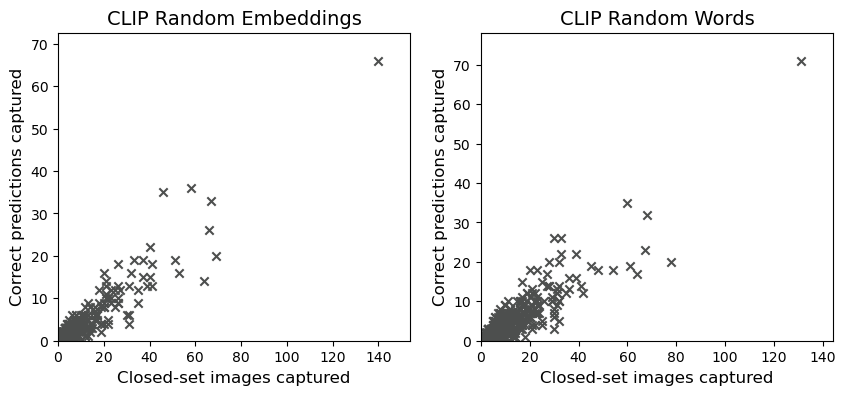

Testing align


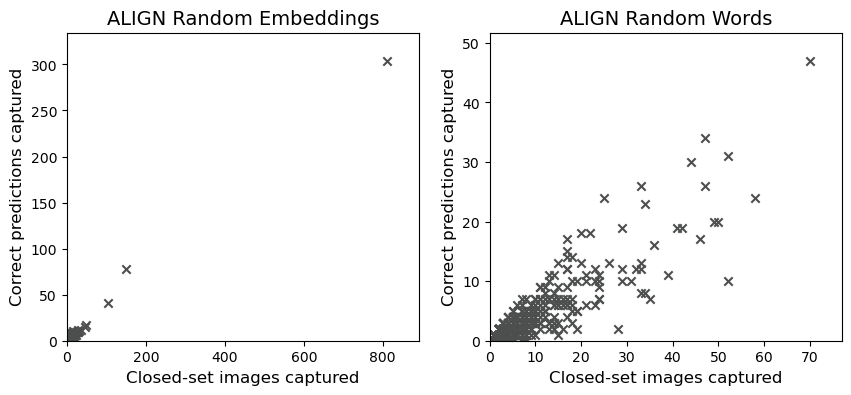

Testing imagebind


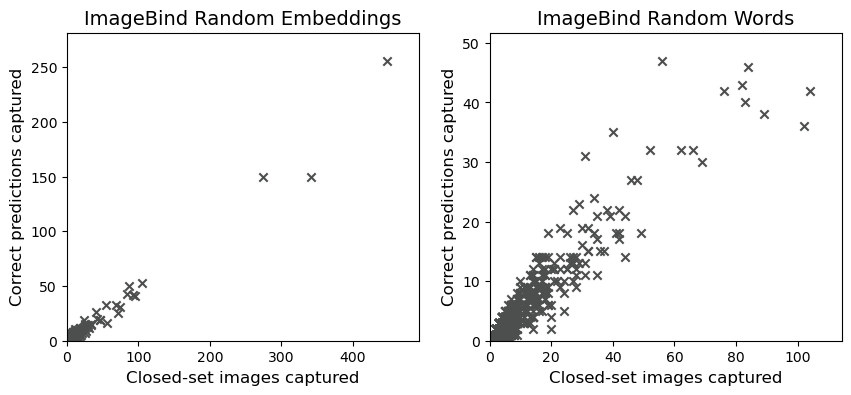

In [39]:
num_neg = 2500
neg_types = 'words'

markerTypes = ['X', 'o', '^']
cols = ['#D85959', '#F59D3B', '#32A7BF', '#545154']

modelNames = ['CLIP', 'ALIGN', 'ImageBind']

for mIdx, modelType in enumerate(['clip', 'align', 'imagebind']):
    print(f'Testing {modelType}')
    fig, ax = plt.subplots(1, 2, figsize = (10, 4))
    for tIdx, typ in enumerate(['emb', 'word']):
        
        num_times_tp = [0 for i in range(2500)]
        num_times_cs = [0 for i in range(2500)]

        gt_labels_neg = np.load(f'../pred_files/{modelType}/imagenet/2500_{typ}_gt_{modelType}.npy')
        all_cosine_neg = np.load(f'../pred_files/{modelType}/imagenet/2500_{typ}_cosine_{modelType}.npy')
        
        gt_labels = np.load(f'../pred_files/{modelType}/imagenet/standard_gt_{modelType}.npy')
        all_cosine = np.load(f'../pred_files/{modelType}/imagenet/standard_cosine_{modelType}.npy')
                
        raw_results = {'softmax': [[], [], []], 'cosine': [[], [], []], 'entropy': [[], [], []]}
        num_classes = 1000
        for idx in range(len(all_cosine)):
            target = gt_labels[idx]    
            cosine = all_cosine[idx]
    
            softmax = scipy.special.softmax(cosine)
            pred_idx = np.argmax(softmax)

            if pred_idx == target: #if this **would** have been a TP, check if it gets misclassified as a neg embedding
                cosine_neg = all_cosine_neg[idx]
                pred_idx = np.argmax(cosine_neg)

                #was this TRUE POSITIVE closed-set image misclassified as a negative embedding
                if pred_idx >= num_classes:
                    num_times_tp[pred_idx-num_classes]+= 1


            
            cosine_neg = all_cosine_neg[idx]
            pred_idx = np.argmax(cosine_neg)

            #was this closed-set image misclassified as a negative embedding
            if pred_idx >= num_classes:
                num_times_cs[pred_idx-num_classes]+= 1
            
        xmax = np.max(num_times_cs)
        xmax += 0.1*xmax
        ymax = np.max(num_times_tp)
        ymax += 0.1*ymax
        
        ax[tIdx].scatter(num_times_cs, num_times_tp, marker = 'x', c = '#4d4f4e')
        ax[tIdx].set_xlabel('Closed-set images captured', fontsize = 12)
        ax[tIdx].set_ylabel('Correct predictions captured', fontsize = 12)
        ax[tIdx].set_xlim(0, xmax)
        ax[tIdx].set_ylim(0, ymax)
        
        if tIdx == 0:
            t = f'{modelNames[mIdx]} Random Embeddings'
        else:
            t = f'{modelNames[mIdx]} Random Words'
            
        ax[tIdx].set_title(t, fontsize = 14)

    fig.savefig(f'../figures/EmbeddingEffectiveness_TP_{modelNames[mIdx]}.pdf', bbox_inches = 'tight')
    plt.show()